<font face="微软雅黑" size=8 color=#A52A2A >`Final Project`

<font face="微软雅黑" size=6 color=#A52A2A >*`Quantitative Investment Analysis(Fall 2021)`*

<font face="微软雅黑" size=6 color=#A52A2A > `Group:`

<font face="微软雅黑" size=6 color=#A52A2A >`欧游 12132987 杨帅 12132997 刘可 12132981`

<font face="微软雅黑" size=6 color=#A52A2A > Read Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
from statsmodels.api import OLS
import math
#TS
from statsmodels.tsa import stattools
from arch import arch_model
from statsmodels.tsa import arima_model
from statsmodels.graphics.tsaplots import *
from arch.unitroot import ADF
#datetime
from matplotlib.dates import DateFormatter,WeekdayLocator,DateLocator,MONDAY,date2num
from datetime import datetime
#k线
%matplotlib inline
import mplfinance as mpf
# This allows multiple outputs from a single jupyter notebook cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#cvx
import cvxopt as cvx
from cvxopt import matrix,solvers

In [2]:
project = pd.read_csv('/Users/liuke/Downloads/HW2021Fall/Quant/FinalProj/finalproj/finalproj.csv',
                     index_col='DATE')

In [3]:
project.index = pd.to_datetime(project.index, format='%Y%m%d')

<font face="微软雅黑" size=4 color=#2E8B57 > 原数据

In [4]:
project.head(3)

,PERMNO,exret,mkt_beta,logme,logbeme,r_2_12,gp,invest_asset
DATE,,,,,,,,
1963-07-31,10006,-0.0479,1.049360,4.947052,0.182105,0.698340,0.182,0.459617
1963-07-31,10014,-0.0027,0.706807,2.408498,0.080984,0.035714,0.257,0.424276
1963-07-31,10030,-0.0663,0.569758,4.493456,NaN,0.246521,NaN,NaN


<font face="微软雅黑" size=4 color=#2E8B57 >检查空值

In [5]:
project.isnull().sum()

PERMNO               0
exret            12841
mkt_beta             0
logme             1766
logbeme         171927
r_2_12              61
gp              118989
invest_asset    123295
dtype: int64

<font face="微软雅黑" size=4 color=#2E8B57 >创建一个包括所有月份的list，原数据共有619个月

In [6]:
dateID = []
for i in project.index.unique():
    dateID.append(str(i).split()[0])
len(dateID)

619

<font face="微软雅黑" size=6 color=#A52A2A >*`1.1 Optimal portfolio via a BARRA model`*

<font face="微软雅黑" size=5 color=#A52A2A >Step 1

<font face="微软雅黑" size=4 color=#A52A2A >①Reset outliers of 5 firm-level characteristics

<font face="微软雅黑" size=4 color=#2E8B57 >用循环计算每个月的1%与99%分位数，并令大于或小于的等于对应分位数

In [7]:
for d in dateID:
    Q01 = project.loc[d].iloc[:,-5:].quantile(0.01)
    Q99 = project.loc[d].iloc[:,-5:].quantile(0.99)
    for j in range(3,8):
        project.loc[d].iloc[:,j][project.loc[d].iloc[:,j]>Q99[j-3]] = Q99[j-3]
        project.loc[d].iloc[:,j][project.loc[d].iloc[:,j]<Q01[j-3]] = Q01[j-3]   

<font face="微软雅黑" size=4 color=#A52A2A >②Standardize its value

<font face="微软雅黑" size=4 color=#2E8B57 >用循环计算每个月，并对该月内的五列五个不同特征值进行当月该列特征值的标准化

In [8]:
project_std = project
for d in dateID:
    for j in range(3,8):
        mean = project.loc[d].iloc[:,j].mean()
        std = project.loc[d].iloc[:,j].std()
        project_std.loc[d].iloc[:,j]=project.loc[d].iloc[:,j].apply(lambda x : (x-mean)/std)

/Applications/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


<font face="微软雅黑" size=4 color=#2E8B57 >标准化完毕

In [9]:
project_std

,PERMNO,exret,mkt_beta,logme,logbeme,r_2_12,gp,invest_asset
DATE,,,,,,,,
1963-07-31,10006,-0.0479,1.049360,0.286460,0.774220,1.434258,-0.655549,3.186066
1963-07-31,10014,-0.0027,0.706807,-1.390264,0.618245,-1.050796,-0.325663,2.896638
1963-07-31,10030,-0.0663,0.569758,-0.013142,NaN,-0.260204,NaN,NaN
1963-07-31,10057,-0.0967,1.135995,-0.680445,NaN,1.124172,NaN,NaN
1963-07-31,10102,-0.0190,0.963979,0.715342,0.021303,-0.516088,-0.202505,0.587275
...,...,...,...,...,...,...,...,...
2015-01-30,93428,-0.0734,1.224872,0.030170,-0.661853,-0.121359,0.386886,0.391627
2015-01-30,93429,0.0166,0.581365,0.895934,-2.339622,0.441129,1.640668,0.779888
2015-01-30,93433,0.5939,2.559842,-2.110162,-3.145233,-2.096343,-0.861179,-1.841682


<font face="微软雅黑" size=4 color=#2E8B57 >进行训练集为前120个月的演示，定义training数据

In [10]:
trainingdate = dateID[:120]
training_start = '1963-7-31'
training_end = '1973-6-30'
training = project_std[training_start:training_end]
training.tail(3)
training.head(3)

,PERMNO,exret,mkt_beta,logme,logbeme,r_2_12,gp,invest_asset
DATE,,,,,,,,
1973-06-29,65825,0.0300,1.275393,-1.266623,0.754495,0.323338,0.204975,-0.228146
1973-06-29,68195,-0.0265,1.179756,0.567518,-1.548156,-1.440666,0.412852,0.044301
1973-06-29,68523,-0.0264,1.450590,-0.080775,NaN,-1.045893,NaN,NaN


,PERMNO,exret,mkt_beta,logme,logbeme,r_2_12,gp,invest_asset
DATE,,,,,,,,
1963-07-31,10006,-0.0479,1.049360,0.286460,0.774220,1.434258,-0.655549,3.186066
1963-07-31,10014,-0.0027,0.706807,-1.390264,0.618245,-1.050796,-0.325663,2.896638
1963-07-31,10030,-0.0663,0.569758,-0.013142,NaN,-0.260204,NaN,NaN


<font face="微软雅黑" size=4 color=#A52A2A >③Cross-sectional regression

#### Collect the resulting coefficient estimates

<font face="微软雅黑" size=4 color=#2E8B57 >收集θ的120个月的时间序列数据，先建立用来存放的表格

In [11]:
θ = pd.DataFrame(data=np.zeros([120,6]),index=training.index.unique(),
                columns=['mkt_beta','logme','logbeme','r_2_12','gp','invest_asset'])

<font face="微软雅黑" size=4 color=#2E8B57 >对每个月进行6个特征值的回归，将系数记录在上面的表格

In [12]:
for t in trainingdate:
    θ.loc[t] = OLS(training.loc[t].iloc[:,1],training.loc[t].iloc[:,2:],missing='drop').fit().params

<font face="微软雅黑" size=4 color=#2E8B57 >得到如下的θ的120个月的数据

In [13]:
θ

,mkt_beta,logme,logbeme,r_2_12,gp,invest_asset
DATE,,,,,,
1963-07-31,-0.009225,-0.001787,-0.006311,0.007078,0.000406,0.001267
1963-08-30,0.047990,0.007174,0.001092,0.009503,0.002422,-0.002563
1963-09-30,-0.022506,0.001859,0.005765,-0.003435,0.004645,-0.003438
1963-10-31,0.020559,-0.001818,0.001067,0.016890,0.004495,-0.000174
1963-11-29,-0.006861,0.000740,-0.000229,-0.000181,-0.006763,-0.001882
...,...,...,...,...,...,...
1973-02-28,-0.052802,0.006952,0.006234,-0.005770,-0.006178,-0.003055
1973-03-30,-0.017573,-0.001362,0.009965,0.009215,-0.005966,0.002347
1973-04-30,-0.051029,0.001509,0.013480,0.009644,-0.006367,-0.008786


In [14]:
#θ.to_csv('/Users/liuke/Downloads/HW2021Fall/Quant/FinalProj/θ.csv')

#### Collect the  residuals of cross-sectional regressions 

<font face="微软雅黑" size=4 color=#2E8B57 >建立收集η的表格

In [15]:
η=pd.DataFrame(data=np.zeros([120,2510]),index=training.index.unique(),
              columns=training.PERMNO.unique())

<font face="微软雅黑" size=4 color=#2E8B57 >由于不是每一个公司都参与回归，有的公司数据残缺，所以这一步需要将残差与公司对号入座

In [16]:
for t in trainingdate:
    testtheta =  training.loc[t]
    testtheta.index = training.loc[t].PERMNO
    dicttest = dict(OLS(testtheta.iloc[:,1],testtheta.iloc[:,2:],missing='drop').fit().resid)
    η.loc[t]=dicttest

In [17]:
#η.to_csv('/Users/liuke/Downloads/HW2021Fall/Quant/FinalProj/η.csv')

<font face="微软雅黑" size=4 color=#2E8B57 >得到如下的120个月的η数据，可以发现，越早上市的公司（100XX），数据越完整，越晚上市的公司（483XX），数据就比较少

In [18]:
η

,10006,10014,10030,10057,10102,10137,10145,10153,10161,10188,...,48346,48354,48362,48370,48389,48397,48418,48426,48434,48442
DATE,,,,,,,,,,,,,,,,,,,,,
1963-07-31,-0.046743,0.009138,NaN,NaN,-0.005704,0.004607,0.028751,-0.063615,-0.090622,-0.038800,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-08-30,0.064502,0.032025,NaN,NaN,0.030122,0.088553,-0.052194,0.005873,-0.005439,0.010307,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-09-30,-0.043745,-0.016979,NaN,NaN,-0.007585,-0.082890,0.031948,-0.051777,-0.038148,0.041821,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-10-31,0.015083,-0.109031,NaN,NaN,0.020517,0.029229,0.048320,-0.046128,-0.014519,-0.044726,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1963-11-29,0.253260,0.006279,NaN,NaN,0.000964,-0.047379,0.019463,-0.008019,0.055317,-0.054098,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1973-02-28,-0.033271,-0.144079,NaN,-0.062460,0.020427,0.006745,0.103987,-0.041335,0.102895,0.025197,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-03-30,0.118891,0.063162,NaN,-0.073148,0.005686,-0.091395,0.071867,-0.065489,0.019426,0.019332,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1973-04-30,0.035180,-0.131197,NaN,0.027674,-0.032529,0.061821,0.003653,0.053667,-0.012713,0.019283,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<font face="微软雅黑" size=5 color=#A52A2A >Step 2 Compute the sample average of factors θt over past 120 months

<font face="微软雅黑" size=4 color=#2E8B57 >求简单均值

In [19]:
θ_1_120 = θ.mean()
θ_1_120

mkt_beta        0.003850
logme          -0.001872
logbeme         0.001044
r_2_12          0.004283
gp              0.000598
invest_asset   -0.001727
dtype: float64

<font face="微软雅黑" size=5 color=#A52A2A >Step 3 Compute the sample covariance matrix of factors θt over past 120 months

<font face="微软雅黑" size=4 color=#2E8B57 >求θ的协方差，注意到分母是训练长度120 - 自由度6，意味着之后训练长度变长，分母也会跟随着变

In [20]:
Var_120 = 0
for t in trainingdate:
    temp = np.array(θ.loc[t] - θ_1_120).reshape([6,1]).dot(np.array(θ.loc[t] - θ_1_120).reshape([1,6]))
    Var_120 += temp
Var_120_θ = Var_120/114
Var_120_θ

array([[ 1.66198661e-03, -2.56172075e-04,  2.52606496e-05,
         2.69375116e-05, -3.04900035e-06,  3.23134228e-06],
       [-2.56172075e-04,  2.60906246e-04,  3.35365257e-05,
        -8.01462900e-06,  1.90901247e-05,  7.43214303e-06],
       [ 2.52606496e-05,  3.35365257e-05,  4.66774031e-05,
        -1.73587973e-05,  6.05526330e-06, -5.57541035e-06],
       [ 2.69375116e-05, -8.01462900e-06, -1.73587973e-05,
         1.56667992e-04,  1.49194906e-05,  9.51424575e-06],
       [-3.04900035e-06,  1.90901247e-05,  6.05526330e-06,
         1.49194906e-05,  3.51728290e-05,  9.38034383e-06],
       [ 3.23134228e-06,  7.43214303e-06, -5.57541035e-06,
         9.51424575e-06,  9.38034383e-06,  2.23785584e-05]])

<font face="微软雅黑" size=5 color=#A52A2A >Step 4 Compute the sample covariance matrix of residuals ηt

<font face="微软雅黑" size=4 color=#2E8B57 >筛选数据主要有三个问题
- 第一是选择在训练最后一期仍在交易的股票
- 第二是选择未来一期仍有交易的股票
- 第三是该股票可用数据大于100的

<font face="微软雅黑" size=4 color=#2E8B57 >这里注意到窗口长度为120时，可用数据筛选的下限是100，之后窗口增大，按理来说应该相应增大可用数据的下限，比如训练200个月，选择可用数据为160以上的股票，但是在任务中没有明确说明，之后我仍以可用数据数量为100来计算

In [21]:
ffdf = training.loc['1973-6-29']
ffdf.index = ffdf.PERMNO
ff1 = ffdf.exret.dropna().index
ff2 = list(η[ff1].columns[η[ff1].count()>100])

ffdf2 = project_std.loc['1973-7-31'].dropna()
ffdf2.index = ffdf2.PERMNO
ffdf2 = ffdf2.exret.dropna()
fff = list(set(ff2).intersection(set(ffdf2.index)))

<font face="微软雅黑" size=4 color=#2E8B57 >股票数据筛选完毕，选出501个股票进行计算，这里对号入座，选则这501个股票的η

In [22]:
η_select = η[fff]
η_select

,10241,20482,22533,22541,18446,24600,12319,26657,16424,26665,...,26606,10225,14322,24563,22517,26614,10233,20474,24571,26622
DATE,,,,,,,,,,,,,,,,,,,,,
1963-07-31,-0.011251,0.148298,-0.022518,0.024621,-0.063550,-0.055881,0.023817,0.016498,0.003755,-0.132050,...,-0.042128,0.005083,-0.014629,0.005142,-0.016592,-0.021744,-0.022991,-0.083933,0.083440,-0.013899
1963-08-30,0.017603,0.044109,0.042719,-0.006570,0.000386,-0.002275,0.040321,-0.041226,0.074791,0.005764,...,-0.016971,-0.018147,-0.006268,0.026555,0.003019,-0.017452,0.102587,0.172863,-0.078579,0.016186
1963-09-30,-0.024069,0.005664,-0.079853,0.012928,0.014544,-0.014532,-0.073607,-0.046684,-0.026716,-0.133519,...,0.008787,-0.036519,0.076087,-0.019692,-0.034220,-0.055316,-0.067037,-0.048555,-0.021698,0.013225
1963-10-31,-0.051019,-0.117208,0.064395,-0.032517,0.003532,0.030844,-0.003088,-0.122484,-0.139527,0.223472,...,0.008548,0.065005,-0.031482,-0.017434,-0.026959,-0.004266,0.148759,-0.026713,-0.034627,-0.032260
1963-11-29,-0.025544,0.057984,0.017964,0.010278,-0.008238,-0.126051,-0.048952,-0.003100,0.023677,-0.022102,...,-0.032847,-0.073273,0.000074,-0.000628,0.020666,-0.054908,-0.056786,0.107381,0.003683,0.014418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1973-02-28,-0.024358,0.034486,-0.022188,0.017539,0.037831,0.084977,0.067960,0.020546,-0.021639,-0.100893,...,-0.012657,-0.048071,0.012760,0.052736,0.008276,-0.009711,-0.084698,-0.056420,-0.053987,-0.046428
1973-03-30,0.028547,0.068959,-0.115656,-0.010005,0.029383,0.116961,0.129184,-0.137262,0.024042,0.057223,...,-0.061776,0.011521,-0.048167,-0.032414,-0.045001,0.010744,-0.128014,-0.035158,-0.021500,0.049639
1973-04-30,0.015737,-0.032109,-0.053337,0.012179,-0.017282,0.249953,0.132061,0.003020,-0.002956,-0.034201,...,0.028581,-0.047598,0.015917,-0.008000,-0.032297,0.013221,0.098124,-0.003202,0.001231,0.096375


In [23]:
η_select.mean()
len_of_select = len(η_select.T)
Var_120_η = np.eye(len_of_select);

<font face="微软雅黑" size=4 color=#2E8B57 >为了储存残差的对角阵，建立储存的表格

In [24]:
Var_120_η = pd.DataFrame(data=Var_120_η,index=[np.arange(len_of_select)+1],columns=[np.arange(len_of_select)+1])
Var_120_η

,1,2,3,4,5,6,7,8,9,10,...,492,493,494,495,496,497,498,499,500,501
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
498,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
500,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


<font face="微软雅黑" size=4 color=#2E8B57 >计算并输入对角阵，这里注意到分母是随着公司可用数据的多少决定的，所以不是常数，最后得到该对角阵

In [25]:
for i in range(len_of_select):
    Var_120_η.iloc[i,i] = (η_select.iloc[:,i].var()*(η_select.iloc[:,i].count()-1))/(η_select.iloc[:,i].count()-6)

In [26]:
Var_120_η

,1,2,3,4,5,6,7,8,9,10,...,492,493,494,495,496,497,498,499,500,501
1,0.002088,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.003625,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.005042,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.001483,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.004387,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.001355,0.000000,0.000000,0.000000,0.000000
498,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.008182,0.000000,0.000000,0.000000
499,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.013988,0.000000,0.000000
500,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.003831,0.000000


<font face="微软雅黑" size=5 color=#A52A2A >Step 5 Compute time-t (June 1973) forecast

In [27]:
θ_1_120

mkt_beta        0.003850
logme          -0.001872
logbeme         0.001044
r_2_12          0.004283
gp              0.000598
invest_asset   -0.001727
dtype: float64

<font face="微软雅黑" size=4 color=#2E8B57 >由于滞后的关系，找到下一期的被选中的公司的特征数据，提取相关的数据

In [28]:
test_e121 = project_std.loc['1973-7-31']
test_e121.index = test_e121.PERMNO
test_e121.loc[fff]

,PERMNO,exret,mkt_beta,logme,logbeme,r_2_12,gp,invest_asset
PERMNO,,,,,,,,
10241,10241,-0.0321,0.557337,1.302578,0.706663,1.452011,-0.297104,-0.633175
20482,20482,0.0834,0.600614,1.538218,-1.210529,0.440673,0.622965,0.373311
22533,22533,0.1499,0.831745,1.212344,-0.679286,-0.258592,-0.162983,0.551184
22541,22541,0.0139,0.847198,1.513147,0.488195,0.988619,-1.203315,0.148674
18446,18446,0.0404,1.450027,1.306052,-0.663061,0.135971,-0.356118,-0.121538
...,...,...,...,...,...,...,...,...
26614,26614,-0.0348,0.276632,-0.074015,-0.040445,0.951292,-1.042370,0.010116
10233,10233,0.1584,1.587835,1.093097,-0.787116,-0.143723,0.343099,-0.115342
20474,20474,0.2209,1.951782,0.389532,1.076514,-0.095613,0.760216,-0.955284


In [29]:
X_120 = test_e121.loc[fff].iloc[:,2:]
X_120

,mkt_beta,logme,logbeme,r_2_12,gp,invest_asset
PERMNO,,,,,,
10241,0.557337,1.302578,0.706663,1.452011,-0.297104,-0.633175
20482,0.600614,1.538218,-1.210529,0.440673,0.622965,0.373311
22533,0.831745,1.212344,-0.679286,-0.258592,-0.162983,0.551184
22541,0.847198,1.513147,0.488195,0.988619,-1.203315,0.148674
18446,1.450027,1.306052,-0.663061,0.135971,-0.356118,-0.121538
...,...,...,...,...,...,...
26614,0.276632,-0.074015,-0.040445,0.951292,-1.042370,0.010116
10233,1.587835,1.093097,-0.787116,-0.143723,0.343099,-0.115342
20474,1.951782,0.389532,1.076514,-0.095613,0.760216,-0.955284


<font face="微软雅黑" size=4 color=#2E8B57 >求得这些被选中公司的下一期的条件期望超额收益

In [30]:
E_121 = (X_120*θ_1_120).sum(axis=1)

<font face="微软雅黑" size=5 color=#A52A2A >Step 6 Compute time-t (June 1973) conditional variance of month-t+1
return (July 1973)

<font face="微软雅黑" size=4 color=#2E8B57 >计算方差

In [31]:
X_120_v = np.array(X_120)

In [32]:
Var_s6 = X_120_v.dot(Var_120_θ).dot(X_120_v.T)+Var_120_η

In [33]:
Var_s6

,1,2,3,4,5,6,7,8,9,10,...,492,493,494,495,496,497,498,499,500,501
1,0.003047,0.000728,0.000678,0.001051,0.001171,0.000822,0.000570,0.000949,0.001193,0.001227,...,0.000490,0.000733,0.001129,0.000997,0.000907,0.000327,0.001175,0.001416,0.001182,0.000969
2,0.000728,0.004401,0.000733,0.000876,0.001121,0.000521,0.000304,0.000881,0.001195,0.001133,...,0.000332,0.000659,0.001174,0.000860,0.000742,0.000193,0.001162,0.001224,0.000883,0.000972
3,0.000678,0.000733,0.006011,0.001007,0.001602,0.001240,-0.000198,0.001044,0.001026,0.002052,...,0.000538,0.000607,0.001125,0.000673,0.000840,0.000258,0.001738,0.002102,0.000694,0.001194
4,0.001051,0.000876,0.001007,0.002804,0.001727,0.001352,0.000291,0.001164,0.001327,0.002039,...,0.000688,0.000831,0.001362,0.001069,0.001128,0.000410,0.001793,0.002192,0.001218,0.001310
5,0.001171,0.001121,0.001602,0.001727,0.007271,0.002639,-0.000344,0.001767,0.001694,0.003968,...,0.001139,0.000881,0.001696,0.001060,0.001488,0.000621,0.003164,0.004037,0.001175,0.002084
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
497,0.000327,0.000193,0.000258,0.000410,0.000621,0.000731,0.000195,0.000208,0.000436,0.000900,...,0.000398,0.000109,0.000265,0.000334,0.000407,0.001666,0.000661,0.000888,0.000395,0.000425
498,0.001175,0.001162,0.001738,0.001793,0.003164,0.002993,-0.000554,0.001968,0.001775,0.004491,...,0.001244,0.000864,0.001736,0.001000,0.001548,0.000661,0.011698,0.004545,0.001120,0.002280
499,0.001416,0.001224,0.002102,0.002192,0.004037,0.004317,-0.000947,0.002592,0.001921,0.006083,...,0.001694,0.000922,0.001820,0.000962,0.001899,0.000888,0.004545,0.020186,0.001252,0.002820
500,0.001182,0.000883,0.000694,0.001218,0.001175,0.000658,0.000968,0.000981,0.001498,0.001020,...,0.000518,0.000892,0.001362,0.001315,0.001065,0.000395,0.001120,0.001252,0.005361,0.001037


<font face="微软雅黑" size=5 color=#A52A2A >Step 7a GMV

<font face="微软雅黑" size=4 color=#2E8B57 >按照最小方差公式计算权重

In [34]:
e = np.ones([len_of_select,1])

In [35]:
w_gmv_120 = np.linalg.inv(Var_s6).dot(e)/(e.T.dot(np.linalg.inv(Var_s6)).dot(e))

In [36]:
R_e_next = test_e121.loc[fff].exret

<font face="微软雅黑" size=4 color=#2E8B57 >得到权重之后，用下一期收益率来获得这个用120个月数据选择的最小方差组合的下一个月的表现

In [37]:
Excess_ret_GMV = w_gmv_120.T.dot(np.array(R_e_next).reshape(len(R_e_next),1))
float(Excess_ret_GMV)

-0.03047561418154594

<font face="微软雅黑" size=5 color=#A52A2A >Step 7b

<font face="微软雅黑" size=4 color=#2E8B57 >使用CVXOPT包求解二次规划问题

<font face="微软雅黑" size=4 color=#2E8B57 >不等式左边系数矩阵g的形成

In [38]:
g1 = pd.DataFrame(data=np.eye(len_of_select))
g2 = pd.DataFrame(data=-1*np.eye(len_of_select))
g = g1.append(g2)

<font face="微软雅黑" size=4 color=#2E8B57 >不等式右边矩阵h

In [39]:
h = pd.DataFrame(data=0.01*np.ones(2*len_of_select).reshape([len_of_select*2,1]))

<font face="微软雅黑" size=4 color=#2E8B57 >等式约束的等式左边系数矩阵A

In [40]:
A1 = X_120[['mkt_beta','logme']]
A1['e'] = 1
A = A1.T;

/var/folders/t0/8lchz22d7wjbvmdj2j9vt7jh0000gn/T/ipykernel_1104/3107406243.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  A1['e'] = 1


<font face="微软雅黑" size=4 color=#2E8B57 >等式约束等式右边矩阵b

In [41]:
b1 = pd.DataFrame(data=np.array([0,0,0])).astype(float)

<font face="微软雅黑" size=4 color=#2E8B57 >二次规划的标准化矩阵

In [42]:
P = matrix(np.matrix(3*Var_s6)) 
q = matrix(np.array(-1*E_121).reshape([len_of_select,1])) 
G = matrix(np.array(g))
h = matrix(np.array(h))
A = matrix(np.array(A))
b = matrix(np.array(b1))

<font face="微软雅黑" size=4 color=#2E8B57 >求解得到多空组合的权重

In [43]:
result = solvers.qp(P,q,G,h,A,b)
w_optLS = np.array(result['x'])

     pcost       dcost       gap    pres   dres
 0: -2.4398e-03 -1.0071e+01  1e+01  9e-17  3e-15
 1: -2.4828e-03 -1.2773e-01  1e-01  6e-17  4e-15
 2: -4.9536e-03 -1.7305e-02  1e-02  7e-17  4e-16
 3: -9.5832e-03 -1.1659e-02  2e-03  1e-16  1e-16
 4: -1.0634e-02 -1.1024e-02  4e-04  1e-16  1e-16
 5: -1.0849e-02 -1.0885e-02  4e-05  9e-17  1e-16
 6: -1.0869e-02 -1.0871e-02  1e-06  2e-16  1e-16
 7: -1.0870e-02 -1.0870e-02  4e-08  2e-16  1e-16
Optimal solution found.


<font face="微软雅黑" size=4 color=#2E8B57 >检查所得多空组合权重的和是否为0

In [44]:
round(w_optLS.sum())

0

<font face="微软雅黑" size=4 color=#2E8B57 >检查所得多空组合的每个元素绝对值是否都小于0.01

In [45]:
(abs(w_optLS) <0.01).sum() == len_of_select

True

<font face="微软雅黑" size=4 color=#2E8B57 >检查是否所得多空组合ß和为0，log(ME)和为0

In [46]:
w_optLS.T.dot(A.T).astype(int)

array([[0, 0, 0]])

<font face="微软雅黑" size=4 color=#2E8B57 >所得多空组合的表现

In [47]:
float(w_optLS.T.dot(np.array(R_e_next).reshape(len(R_e_next),1)))

-0.04569814043420194

<font face="微软雅黑" size=5 color=#A52A2A >Step 8

<font face="微软雅黑" size=4 color=#2E8B57 >建立一个储存两个组合收益表现的表格

In [50]:
ExcessRet_of_2 = pd.DataFrame(data=np.zeros([619,2]),index = project.index.unique(),
                             columns=['GMV','long-short']).iloc[120:]

In [51]:
ExcessRet_of_2.iloc[:,:] = np.nan
ExcessRet_of_2

,GMV,long-short
DATE,,
1973-07-31,NaN,NaN
1973-08-31,NaN,NaN
1973-09-28,NaN,NaN
1973-10-31,NaN,NaN
1973-11-30,NaN,NaN
...,...,...
2014-09-30,NaN,NaN
2014-10-31,NaN,NaN
2014-11-28,NaN,NaN


<font face="微软雅黑" size=4 color=#2E8B57 >将以上步骤进行整合，再循环求得两个组合表现的时间序列数据

In [ ]:
for month in range(119,618):
    #设置训练集，每次循环都会使得训练月长度越来越大，逐渐变大的窗口，但是开始的时间固定
    trainingdate = dateID[:month+1]
    training = project_std['1963-7-31':dateID[month]]
    
    #Step1 标准化早已完成，现在收集本次循环的θ和η
    #创建收集表，形状是当次循环包含训练集的长度*6
    θ_s8 = pd.DataFrame(data=np.zeros([month+1,6]),index=training.index.unique(),
                    columns=['mkt_beta','logme','logbeme','r_2_12','gp','invest_asset'])
    #进行回归，month-by-month的回归并写入数据表中，收集θ
    for t1 in trainingdate:
        θ_s8.loc[t1] = OLS(training.loc[t1].iloc[:,1],training.loc[t1].iloc[:,2:],missing='drop').fit().params
    #建立η表，收集每一个公司的每一个月的η，表格形状为月份数量*公司数量，
    η_s8 = pd.DataFrame(data=np.zeros([month+1,len(training.PERMNO.unique())]),index=training.index.unique(),
              columns=training.PERMNO.unique())
    #回归并提取η，利用dict将每个η和它所属于的公司对号入座，确保公司对应自己的当月的η
    for t2 in trainingdate:
        testtheta =  training.loc[t2]
        testtheta.index = training.loc[t2].PERMNO
        dicttest = dict(OLS(testtheta.iloc[:,1],testtheta.iloc[:,2:],missing='drop').fit().resid)
        η_s8.loc[t2]=dicttest
    
    #Step2 θ样本均值
    θ_1_120_s8 = θ_s8.mean()

    #Step3 θ样本协方差
    Var_120_s8 = 0
    for t3 in trainingdate:
        temp = np.array(θ_s8.loc[t3] - θ_1_120_s8).reshape([6,1]).dot(np.array(θ_s8.loc[t3] - θ_1_120_s8).reshape([1,6]))
        Var_120_s8 += temp
    Var_120_θ_s8 = Var_120_s8/(month-5) #month + 1 - 6,取120个月时，month=119，自由度：119+1-6 = 114

    #Step4 η协方差
    ffdf = training.loc[dateID[month]]
    ffdf.index = ffdf.PERMNO
    ff1 = ffdf.exret.dropna().index
    ff2 = list(η_s8[ff1].columns[η_s8[ff1].count()>100])

    ffdf2 = project_std.loc[dateID[month+1]].dropna()
    ffdf2.index = ffdf2.PERMNO
    ffdf2 = ffdf2.exret.dropna()
    fff = list(set(ff2).intersection(set(ffdf2.index)))
    #数据选择完毕，进行计算
    η_select_s8 = η_s8[fff]
    len_of_select_s8 = len(η_select_s8.T)
    #建立收集表
    Var_120_η_s8 = np.eye(len_of_select_s8);
    Var_120_η_s8 = pd.DataFrame(data=Var_120_η_s8,index=[np.arange(len_of_select_s8)+1],columns=[np.arange(len_of_select_s8)+1])
    #求对角线上每一个数字，分母Bi是变化的，视每个公司情况而定
    for t4 in range(len_of_select_s8):
        Var_120_η_s8.iloc[t4,t4] = (η_select_s8.iloc[:,t4].var()*(η_select.iloc[:,i].count()-1))/(η_select_s8.iloc[:,t4].count()-6)
    
    #Step 5 下一期期望收益，由于滞后一期的关系，系数用下一期的
    e_s5 = project_std.loc[dateID[month+1]];
    e_s5.index = e_s5.PERMNO;
    X_120_s8 = e_s5.loc[fff].iloc[:,2:];
    E_121_s8 = (X_120_s8*θ_1_120_s8).sum(axis=1);
    
    #Step 6 下一期条件方差
    X_120_s8_v = np.array(X_120_s8)
    Var_s6_s8 = X_120_s8_v.dot(Var_120_θ_s8).dot(X_120_s8_v.T)+Var_120_η_s8;

    #Step 7a GMV
    R_e_next =e_s5.loc[fff].exret
    e = np.ones([len_of_select_s8,1])
    w_gmv_120_s8 = np.linalg.inv(Var_s6_s8).dot(e)/(e.T.dot(np.linalg.inv(Var_s6_s8)).dot(e))
    Excess_ret_GMV_s8 = float(w_gmv_120_s8.T.dot(np.array(R_e_next).reshape(len(R_e_next),1)))
    
    #Step 7b long-short
    g1 = pd.DataFrame(data=np.eye(len_of_select_s8))
    g2 = pd.DataFrame(data=-1*np.eye(len_of_select_s8))
    g = g1.append(g2)
    h = pd.DataFrame(data=0.01*np.ones(2*len_of_select_s8).reshape([len_of_select_s8*2,1]))
    A1 = X_120_s8[['mkt_beta','logme']]
    A1['e'] = 1
    A = A1.T;
    b1 = pd.DataFrame(data=np.array([0,0,0])).astype(float)
    P = matrix(np.matrix(3*Var_s6_s8)) #!
    q = matrix(np.array(-1*E_121_s8).reshape([len_of_select_s8,1])) #!
    G = matrix(np.array(g))#!
    h = matrix(np.array(h))#
    A = matrix(np.array(A));
    b = matrix(np.array(b1));
    result = solvers.qp(P,q,G,h,A,b);
    w_optLS_s8 = np.array(result['x']);
    Excess_ret_ls_s8 = float(w_optLS_s8.T.dot(np.array(R_e_next).reshape(len(R_e_next),1)));
    
    #Record
    ExcessRet_of_2.loc[dateID[month+1]]['GMV'] = Excess_ret_GMV_s8
    ExcessRet_of_2.loc[dateID[month+1]]['long-short'] = Excess_ret_ls_s8

In [48]:
#ExcessRet_of_2.to_csv('/Users/liuke/Downloads/HW2021Fall/Quant/FinalProj/record.csv')

<font face="微软雅黑" size=4 color=#2E8B57 >将两组合表现数据存档

In [49]:
Perfomence = pd.read_csv('/Users/liuke/Downloads/HW2021Fall/Quant/FinalProj/ExcessRet_TS.csv',index_col='DATE')
Perfomence.index = pd.to_datetime(Perfomence.index)

<font face="微软雅黑" size=4 color=#2E8B57 >画出收益率的折线图，大体在0附近上下波动

<AxesSubplot:xlabel='DATE'>

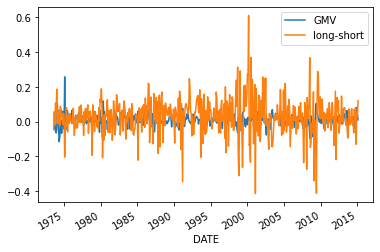

In [50]:
Perfomence.plot()

<font face="微软雅黑" size=4 color=#2E8B57 >具体数据如下

In [51]:
Perfomence

,GMV,long-short
DATE,,
1973-07-31,-0.030070,-0.045562
1973-08-31,-0.044310,0.057972
1973-09-28,0.033216,-0.020284
1973-10-31,-0.051882,0.105971
1973-11-30,-0.064184,0.055607
...,...,...
2014-09-30,-0.005530,0.077052
2014-10-31,0.081516,-0.130269
2014-11-28,0.019264,0.053737


<font face="微软雅黑" size=6 color=#A52A2A >*`1.2 Performance Evaluation`*

<font face="微软雅黑" size=5 color=#A52A2A >Preparation 

In [52]:
riskfactor = pd.read_csv('/Users/liuke/Downloads/HW2021Fall/Quant/FinalProj/finalproj/riskfactor.csv',index_col='date')
riskfactor.index = pd.to_datetime(riskfactor.index,format='%Y%m%d')

In [53]:
Perfomence['Enhanced_index'] = riskfactor.Mkt_RF[-499:] + Perfomence['long-short']

<font face="微软雅黑" size=4 color=#2E8B57 >两个组合在499个月中，收益大于0的天数为

In [54]:
(Perfomence>0).sum()

GMV               331
long-short        326
Enhanced_index    337
dtype: int64

<font face="微软雅黑" size=4 color=#2E8B57 >无风险收益率与市场超额收益大于0的天数，发现无风险收益率在绝大多数情况是大于零的，市场超额收益大于0的天数，与组合的超额完成收益大于0的天数相仿

In [55]:
(riskfactor>0).sum()

Mkt_RF    362
RF        573
dtype: int64

<font face="微软雅黑" size=4 color=#2E8B57 >记录最小方差组合与指数增强组合，接下来进行业绩评价

In [56]:
Min_var = Perfomence['GMV']
Enhanced_index = Perfomence['Enhanced_index']

<font face="微软雅黑" size=5 color=#A52A2A >1.Annualized average excess return:

###  Minimal variance portfolio

In [57]:
Min_var.mean()*12

0.10247648406700628

### Enhanced index portfolio

In [58]:
Enhanced_index.mean()*12

0.419551841705897

<font face="微软雅黑" size=5 color=#A52A2A >2.Annualized standard deviation of excess return:

### Minimal variance portfolio

In [59]:
Min_var.std()*(12**0.5)

0.11560336815664732

### Enhanced index portfolio

In [60]:
Enhanced_index.std()*(12**0.5)

0.389980992988152

<font face="微软雅黑" size=5 color=#A52A2A >3. Annualized Sharpe ratio:

### Minimal variance portfolio

In [61]:
(Min_var.mean()*12) / (Min_var.std()*(12**0.5))

0.8864489478208493

### Enhanced index portfolio

In [62]:
(Enhanced_index.mean()*12) / (Enhanced_index.std()*(12**0.5))

1.0758263844890599

<font face="微软雅黑" size=5 color=#A52A2A >4. Annualized CAPM alpha and t-stats:

### Minimal variance portfolio

In [63]:
model_minvar = OLS(Min_var,sm.add_constant(riskfactor.Mkt_RF[-499:])).fit()
print(model_minvar.summary())

                            OLS Regression Results                            
Dep. Variable:                    GMV   R-squared:                       0.327
Model:                            OLS   Adj. R-squared:                  0.326
Method:                 Least Squares   F-statistic:                     241.7
Date:                Sat, 22 Jan 2022   Prob (F-statistic):           1.06e-44
Time:                        21:55:01   Log-Likelihood:                 1087.9
No. Observations:                 499   AIC:                            -2172.
Df Residuals:                     497   BIC:                            -2163.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0062      0.001      5.027      0.0

#### Minimal variance portfolio αp

In [64]:
model_minvar.params[0]*12

0.07454201250238879

#### Minimal variance portfolio t(αp)

In [65]:
model_minvar.tvalues[0]

5.026864104356599

### Enhanced index portfolio

In [66]:
model_Enhanced = OLS(Enhanced_index,sm.add_constant(riskfactor.Mkt_RF[-499:])).fit()
print(model_Enhanced.summary())

                            OLS Regression Results                            
Dep. Variable:         Enhanced_index   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.110
Method:                 Least Squares   F-statistic:                     62.78
Date:                Sat, 22 Jan 2022   Prob (F-statistic):           1.53e-14
Time:                        21:55:01   Log-Likelihood:                 412.00
No. Observations:                 499   AIC:                            -820.0
Df Residuals:                     497   BIC:                            -811.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0304      0.005      6.341      0.0

#### Enhanced index portfolio: αp

In [67]:
model_Enhanced.params[0]*12

0.3643800562456526

#### Enhanced index portfolio: t(αp)

In [68]:
model_Enhanced.tvalues[0]

6.340938117781441

<font face="微软雅黑" size=5 color=#A52A2A >5. CAPM beta βp and annualized systematic volatility

### Minimal variance portfolio

In [69]:
model_minvar.params[1]

0.4132073287428889

In [70]:
model_minvar.params[1] * (Min_var.std()*(12**0.5))

0.047768158949688985

### Enhanced index portfolio βp and annualized systematic volatility

In [71]:
model_Enhanced.params[1]

0.8161022856390496

In [72]:
model_Enhanced.params[1] * (Enhanced_index.std()*(12**0.5))

0.31826437973341704

<font face="微软雅黑" size=5 color=#A52A2A >6. Annualized idiosyncratic volatility (or tracking errors):


### Minimal variance portfolio

In [73]:
model_minvar.resid.std()*(12**0.5)

0.09482333805923192

### Enhanced index portfolio

In [74]:
model_Enhanced.resid.std()*(12**0.5)

0.36746193220935164

<font face="微软雅黑" size=5 color=#A52A2A >7. R2 of the preceding time series regression, p=1,3

### Minimal variance portfolio

In [75]:
model_minvar.rsquared

0.32719454482498966

### Enhanced index portfolio

In [76]:
model_Enhanced.rsquared

0.11215362234422033

<font face="微软雅黑" size=5 color=#A52A2A >8. Information ratio (relative to the CAPM): αp σ(et)
, p=1,3

### Minimal variance portfolio

In [77]:
model_minvar.params[0] / model_minvar.resid.std()*(12**0.5)

0.7861146214429374

### Enhanced index portfolio

In [78]:
model_Enhanced.params[0] / model_Enhanced.resid.std()*(12**0.5)

0.9916130741892925

<font face="微软雅黑" size=5 color=#A52A2A >9. Maximal Drawdown (not annualized) of the cumulative portfolio return, p=1,3

### def MaxDrawdown

In [79]:
def MaxDrawdown(return_list):
    '''最大回撤率'''
    i = np.argmax((np.maximum.accumulate(return_list) - return_list) / np.maximum.accumulate(return_list))  #最低点
    if i == 0:
        return 0
    j = np.argmax(return_list[:i])  #最高点
    a = (return_list[j] - return_list[i]) / (return_list[j])
    b = (return_list.index[i])
    c = (return_list.index[j])
    return (a,c,b)
def MaxDrawdownPlot(Fund):
    date1 = MaxDrawdown((Fund+1).cumprod())[1]
    date2 = MaxDrawdown((Fund+1).cumprod())[2]
    plt.plot((Fund+1).cumprod())
    x = [date1,date2]
    y = [(Fund+1).cumprod()[date1],(Fund+1).cumprod()[date2]]
    plt.scatter(x, y, color='r')

###  Cumulative wealth

In [80]:
CW_Min_var = (Min_var + riskfactor.RF[-499:]+1).cumprod()
CW_Enhanced_index = (Enhanced_index + riskfactor.RF[-499:]+1).cumprod()

### Minimal variance portfolio

In [81]:
MaxDrawdown(CW_Min_var)[0]

0.34718172346861464

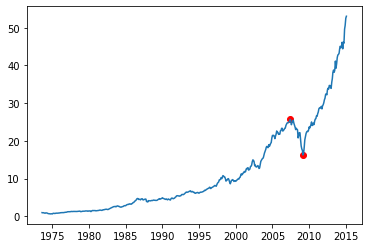

In [97]:
MaxDrawdownPlot((Min_var+riskfactor.RF[-499:]))

### Enhanced index portfolio

In [83]:
MaxDrawdown(CW_Enhanced_index)[0]

0.8282986861801551

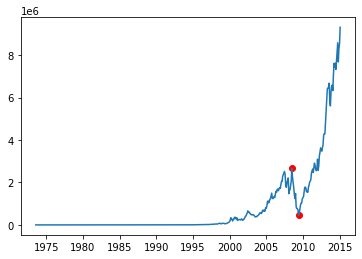

In [100]:
MaxDrawdownPlot((Enhanced_index+riskfactor.RF[-499:]))

<font face="微软雅黑" size=5 color=#A52A2A >10. Maximal Recovery Period (not annualized) of the cumulative portfolio wealth, p=1,3

### def MaximalRecoveryPeriod

In [85]:
def MaximalRecoveryPeriod(test2):
    test3=0
    test4=[]
    for i in range(len(test2)):
        a = (test2.iloc[i] - test3)
        if float(a) < 0:
            pass
        else:
            test3 = test2.iloc[i]
            test4.append(i)
    test5 = []
    for o in range(len(test4)-1):
        test5.append( test4[o+1] - test4[o] )
        b =  max(test5)
    return b

### Minimal variance portfolio

In [86]:
print('Maximal Recovery Period for the {} is: '.format(i),MaximalRecoveryPeriod(CW_Min_var),'months')

Maximal Recovery Period for the 500 is:  30 months


### Enhanced index portfolio

In [87]:
print('Maximal Recovery Period for the {} is: '.format(i),MaximalRecoveryPeriod(CW_Enhanced_index),'months')

Maximal Recovery Period for the 500 is:  36 months


<font face="微软雅黑" size=6 color=#A52A2A >*`1.3Discussions`*

<font face="微软雅黑" size=5 color=#A52A2A >1.Summarize the way in which you construct the two trading strategies

<font face="微软雅黑" size=4 color=black >A:For the minimum variance portfolio, it is the framework of the mean variance model, in which the calculation of stock selection and expected return uses the BARRA model. The long-short portfolio uses the BARRA model to calculate the required parameters, and applies these parameters to the quadratic programming with constraints to obtain the weight of the long-short portfolio. The procedure above is explained in more detail.

<font face="微软雅黑" size=5 color=#A52A2A >2.Draw the cumulative wealth series of the two strategies.

### Minimal variance portfolio

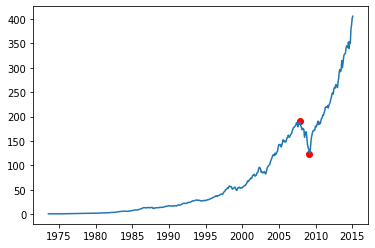

In [88]:
MaxDrawdownPlot((Min_var+riskfactor.RF[-499:]))

### Enhanced index portfolio

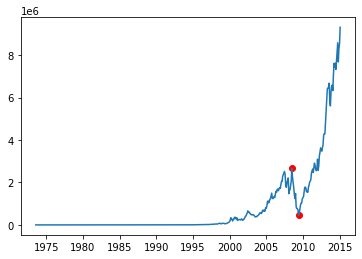

In [89]:
MaxDrawdownPlot((Enhanced_index+riskfactor.RF[-499:]))

<font face="微软雅黑" size=5 color=#A52A2A >3.Compute the first three performance measures of the market excess return

<font face="微软雅黑" size=5 color=black> Annualized average excess return: MinVar `<` Enhanced_index;  
                                                                                                  Annualized standard deviation of excess return: MinVar `<` Enhanced_index;  
    Annualized Sharpe ratio:MinVar `<` Enhanced_index

<font face="微软雅黑" size=5 color=#A52A2A >4.For the rest of performance measures, you compare their values

<font face="微软雅黑" size=5 color=black>Annualized CAPM alpha and t-stats:MinVar `<` Enhanced_index  
    CAPM beta βp and annualized systematic volatility:MinVar `<` Enhanced_index  
    Annualized idiosyncratic volatility:MinVar `<` Enhanced_index  
    R2:MinVar `>` Enhanced_index  
    Information ratio:MinVar `<` Enhanced_index  
    Maximal Drawdown:MinVar `<<` Enhanced_index  
    Maximal Recovery Period:MinVar `<` Enhanced_index  
    

<font face="微软雅黑" size=5 color=#A52A2A >5.Describe the performance of the two strategies

<font face="微软雅黑" size=5 color=black>Average Returns:MinVar `<` Enhanced_index  
                                                                            Alpha: MinVar `<` Enhanced_index  
                                                                            Volatility:  MinVar `<` Enhanced_index  
                                                                                                    Market beta:  MinVar `<` Enhanced_index  
    Maximal drawdown:  MinVar `<` Enhanced_index  
                                  Sharpe ratio:  MinVar `<` Enhanced_index  
    Information ratio:MinVar `<` Enhanced_index 
                                                                            
                                                                            
    
    

<font face="微软雅黑" size=5 color=#A52A2A >6.Suppose you plan to invest your total wealth in one of the two strategies

<font face="微软雅黑" size=5 color=black>A:Choose the one with a high Sharpe ratio, so choose enhanced index portfolio, because the Sharpe ratio is a measure of total risk

<font face="微软雅黑" size=5 color=#A52A2A >7.Finally suggest at least one way to improve the two strategies

<font face="微软雅黑" size=5 color=black>A:Both strategies have no stop loss, and a stop loss condition should be added to the strategy.

<font face="微软雅黑" size=7 color=#A52A2A >*`END`*

<font face="微软雅黑" size=6 color=#A52A2A >*`Quantitative Investment Analysis(Fall 2021)`*

<font face="微软雅黑" size=5 color=#A52A2A >*`欧游12132987/杨帅12132997/刘可12132981`*